In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy.random as npr
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error, precision_recall_curve, roc_curve, r2_score, ConfusionMatrixDisplay, auc, roc_auc_score, precision_score, recall_score
import seaborn as sns
from sklearn import metrics

In [36]:
df = pd.read_csv("./updated_dataset.csv")

feature_names = df.columns.tolist()
print(feature_names)

['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']


In [37]:
X = df.drop(columns=['status'])
t = df['status']

In [38]:
X.drop(columns=['name'], inplace=True)

In [39]:
# if the data and the target a seperate:
#df = pd.concat([data,target], axis 1)

# get the pearons correlation coefficient 
corr_matrix = df.corr(method='pearson', numeric_only=True)

# get the largest correlated feature 
target = 'status'
best_feature = corr_matrix[target].drop(target).idxmax()
print(f"Feature with the largest predictive value for Target is: '{best_feature}'")

# get the value of the highest corrleted feature 
highest_cor_feat = corr_matrix[target].drop(target).max()
print(f"The Pearson Coefficent Value is: {highest_cor_feat:.2f} ")

# print the Correlation Values by order 
corr_matrix[target].sort_values(ascending=False)

Feature with the largest predictive value for Target is: 'spread1'
The Pearson Coefficent Value is: 0.07 


status              1.000000
spread1             0.069917
spread2             0.060992
PPE                 0.052068
DFA                 0.045276
RPDE                0.043618
D2                  0.042601
MDVP:PPQ            0.040487
MDVP:Jitter(Abs)    0.038609
MDVP:Shimmer        0.033306
MDVP:Shimmer(dB)    0.032957
Shimmer:DDA         0.030308
Jitter:DDP          0.027275
MDVP:RAP            0.020507
MDVP:APQ            0.013395
Shimmer:APQ5        0.009143
NHR                -0.022492
MDVP:Fhi(Hz)       -0.043319
MDVP:Jitter(%)     -0.043815
MDVP:Flo(Hz)       -0.049709
Shimmer:APQ3       -0.061459
MDVP:Fo(Hz)        -0.061641
HNR                -0.063360
Name: status, dtype: float64

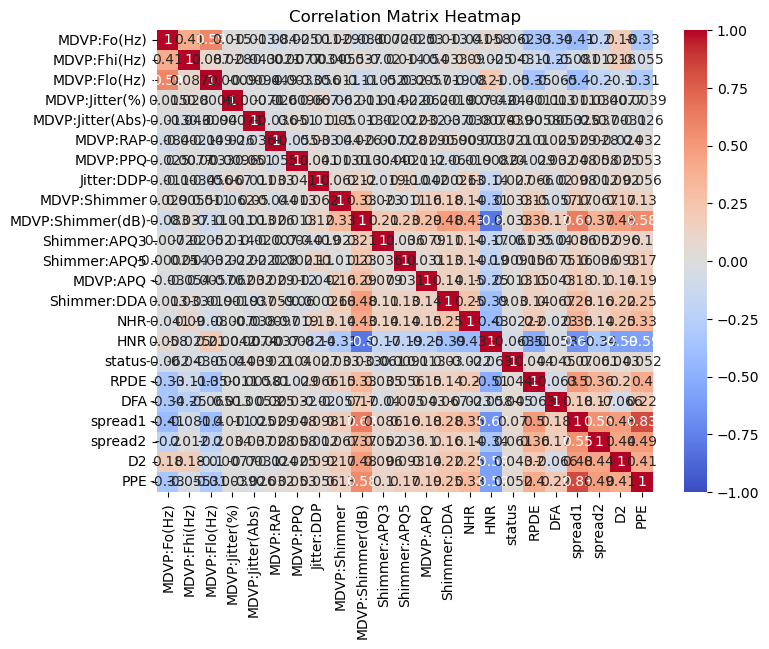

In [40]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [41]:
# PIPELINE: If the data is seperated in Data X and Target y
X_train, X_test, t_train, t_test = train_test_split(X, t, 
                                                    test_size =0.2,
                                                    random_state=42,
                                                    shuffle=True, 
                                                    stratify=t)

In [42]:
classifier = {
    "SVM": Pipeline(steps=[('scaler', StandardScaler()),
                           ('svm',SVC(kernel='rbf'))]),
    "rf": Pipeline(steps=[('scaler', StandardScaler()),
                                     ('rf', RandomForestClassifier())])   
}

param_grids = {
    "SVM": {
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': [0.001, 0.01, 0.1, 1]
        },
    "rf": {
        'rf__n_estimators': [10, 20, 30, 40, 50, 60, 80, 100, 120, 140, 160, 180, 200, 220],
        'rf__criterion': ['gini', 'entropy'],
        'rf__max_depth': [5,6,7]
        }
}

for name, classifier in classifier.items():
    print("Training:", name)
    # Set up GridSearchCV with cross-validation

    grid_search = GridSearchCV(
        estimator=classifier,
        param_grid=param_grids[name],
        cv=KFold(n_splits=5, shuffle=True, random_state=0),
        scoring='accuracy',  # Choose appropriate scoring metric
        refit=True,
        n_jobs=-1  # Use all available cores for parallel processing
        )
    
    # Fit the model
    grid_search.fit(X_train, t_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Print the best parameters
    print("Best Parameters:", best_params)

Training: SVM
Best Parameters: {'svm__C': 10, 'svm__gamma': 0.1}
Training: rf
Best Parameters: {'rf__criterion': 'entropy', 'rf__max_depth': 7, 'rf__n_estimators': 120}


In [43]:
y_train = best_model.predict(X_train)
y_test = best_model.predict(X_test)

Training set performance:
Accuracy: 0.974
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       367
           1       0.96      1.00      0.98       433

    accuracy                           0.97       800
   macro avg       0.98      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800

Accuracy: 0.974
Test set performance:
Accuracy: 0.530
              precision    recall  f1-score   support

           0       0.49      0.50      0.49        92
           1       0.57      0.56      0.56       108

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.53      0.53       200

Accuracy: 0.530


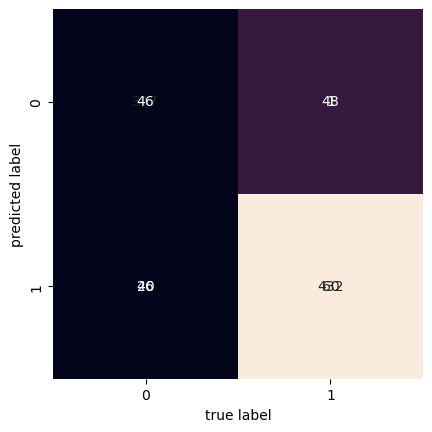

In [44]:
# TRAINING SET 
print('Training set performance:')

# ACCURACY AND CLASSIFICATION REPORT
accuracy = metrics.accuracy_score(t_train, y_train)
print("Accuracy: %.3f" % accuracy)
print(classification_report(t_train, y_train))

# CONFUION MATRIX FOR THE TEST SET
accuracy = metrics.accuracy_score(t_train, y_train)
print("Accuracy: %.3f" % accuracy)

cm = metrics.confusion_matrix(t_train, y_train)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

# TEST SET 
print('Test set performance:')

# ACCURACY AND CLASSIFICATION REPORT
accuracy = metrics.accuracy_score(t_test, y_test)
print("Accuracy: %.3f" % accuracy)
print(classification_report(t_test, y_test))

# CONFUION MATRIX FOR THE TEST SET
accuracy = metrics.accuracy_score(t_test, y_test)
print("Accuracy: %.3f" % accuracy)

cm = metrics.confusion_matrix(t_test, y_test)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

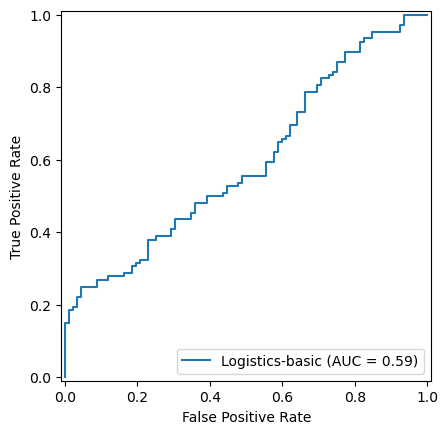

In [45]:
# Plot ROC/AUC curve
fpr, tpr, thresholds = metrics.roc_curve(t_test,best_model.predict_proba(X_test)[:,1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='Logistics-basic')
display.plot()

plt.show()

In [46]:
# For single class predictions using cross-validation
z_train = cross_val_predict(pipeline, X_train, t_train, 
                             cv=10, method='decision_function')

precision, recall, thresholds = precision_recall_curve(t_train, z_train)

plt.plot(recall, precision)
plt.xlabel('Recall', size=15)
plt.ylabel('Precision', size=15);

NameError: name 'pipeline' is not defined